## Mini Project 03- NLP Emotions: Hyper-Parameters/ Stacking

Dataset:
- A. Tripathi, "Emotion Classification NLP", Kaggle.com, 2021. [Online]. Available: https://www.kaggle.com/datasets/anjaneyatripathi/emotion-classification-nlp. [Accessed: 16- Jul- 2022].

Sources:
- WASSA-2017 Shared Task on Emotion Intensity. Saif M. Mohammad and Felipe Bravo-Marquez. In Proceedings of the EMNLP 2017 Workshop on Computational Approaches to Subjectivity, Sentiment, and Social Media (WASSA), September 2017, Copenhagen, Denmark.
BibTex

Emotion Labels:
- joy: 1
- sadness: 2
- anger: 3
- fear: 4

### Import Libraries

In [82]:
## Import Libraries
import numpy as np
import pandas as pd
import math
import re as regex
import spacy
from pathlib import Path
import time
from scipy import stats

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split

from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import plot_confusion_matrix
from simple_colors import *
from sklearn.metrics import f1_score

import itertools
import string
from collections import Counter
import re as regex
from sklearn import metrics
from sklearn import datasets

from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions

from sklearn.ensemble import AdaBoostClassifier

from sklearn.metrics import classification_report

# from sklearn.decomposition import LatentDirichletAllocation
# from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier

import neattext.functions as nfx
import nltk

import warnings
warnings.filterwarnings('ignore')

import import_ipynb
import nlpEmotion_functions
from nlpEmotion_functions import show_summary_report, svcRocPrecisionRecall
from nlpEmotion_functions import probaRocPrecisionRecall, testRocPrecisionRecall, calcRocAuc
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV
# from mlxtend.classifier import StackingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.calibration import CalibratedClassifierCV

%matplotlib inline

### Load Data

In [83]:
dfData= pd.read_csv("convertedTextDataset.csv")
dfModelResults= pd.read_csv("modelPhase01ResultSummary.csv")
dfNlpFeatures = pd.read_csv("nlpTrainFeatures.csv")

In [84]:
dfData.head()

,Unnamed: 0,text,label,short
0,0,Just got back from seeing @GaryDelaney in Burs...,1,get see burslem amaze face hurt laugh hilarious
1,1,Oh dear an evening of absolute hilarity I don'...,1,dear even absolute hilarity don think laugh lo...
2,2,Been waiting all week for this game ❤️❤️❤️ #ch...,1,wait week game red heart red heart red heart c...
3,3,"@gardiner_love : Thank you so much, Gloria! Yo...",1,thank gloria sweet thoughtful day joyful love ...
4,4,I feel so blessed to work with the family that...,1,feel bless work family nanny red heart love am...


In [85]:
dfData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7102 entries, 0 to 7101
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  7102 non-null   int64 
 1   text        7102 non-null   object
 2   label       7102 non-null   int64 
 3   short       7097 non-null   object
dtypes: int64(2), object(2)
memory usage: 222.1+ KB


In [86]:
dfData.drop(['Unnamed: 0'], axis= 1, inplace= True)

In [87]:
dfData.shape

(7102, 3)

In [88]:
dfModelResults

,Unnamed: 0,Count Vectors,WordLevel TF-IDF,N-Gram Vectors,CharLevel Vectors
0,Naïve Bayes,0.830401,0.808586,0.395496,0.695285
1,Logistic Regression,0.843068,0.847994,0.395496,0.779733
2,Support Vector Machine,0.836031,0.855032,0.388459,0.802956
3,Random Forest,0.831809,0.823364,0.387051,0.762843
4,Gradient Boosting,0.812808,0.809993,0.384236,0.788881


In [89]:
dfResults= dfModelResults.rename(columns={'Unnamed: 0': 'Model'})

In [90]:
dfResults

,Model,Count Vectors,WordLevel TF-IDF,N-Gram Vectors,CharLevel Vectors
0,Naïve Bayes,0.830401,0.808586,0.395496,0.695285
1,Logistic Regression,0.843068,0.847994,0.395496,0.779733
2,Support Vector Machine,0.836031,0.855032,0.388459,0.802956
3,Random Forest,0.831809,0.823364,0.387051,0.762843
4,Gradient Boosting,0.812808,0.809993,0.384236,0.788881


From the comparison results dataframe, the top 3 models are:
- Logistic Regression (WordLevel TF-IDF): 0.8479
- Support Vector Machine ((WordLevel TF-IDF): 0.8550
- Random Forest (Count Vectors): 0.8289
- MultinomialNB (Count Vectors): 0.8304

Will implement hyper-parameters and ensemble methods to increase the accuracy values

In [91]:
dfNlpFeatures.head()

,Unnamed: 0,text,label,short,char_count,word_count,word_density,adj_count,adv_count,noun_count,num_count,pron_count,propn_count,verb_count
0,0,Just got back from seeing @GaryDelaney in Burs...,1,get see burslem amaze face hurt laugh hilarious,110,17,6.470588,2,5,5,0,0,2,5
1,1,Oh dear an evening of absolute hilarity I don'...,1,dear even absolute hilarity don think laugh lo...,94,20,4.700000,2,2,2,0,2,0,2
2,2,Been waiting all week for this game ❤️❤️❤️ #ch...,1,wait week game red heart red heart red heart c...,60,11,5.454545,1,0,0,0,0,1,1
3,3,"@gardiner_love : Thank you so much, Gloria! Yo...",1,thank gloria sweet thoughtful day joyful love ...,129,24,5.375000,3,6,6,0,6,1,3
4,4,I feel so blessed to work with the family that...,1,feel bless work family nanny red heart love am...,114,22,5.181818,2,1,1,0,5,2,6


In [92]:
dfNlpFeatures.drop(['Unnamed: 0'], axis= 1, inplace= True)

### Split the data into train and test sets

In [93]:
## split the dataset
# Features and Labels
X= dfData['short']
y= dfData['label']
# XnlpFeatures= dfNlpFeatures.iloc[:, 2:]
# ynlpFeatures= dfNlpFeatures[dfNlpFeatures.columns[1]]
# split the dataset
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size= 0.2, random_state= 42)
# X_train, X_test, y_train, y_test= train_test_split(XnlpFeatures, ynlpFeatures, test_size= 0.2,
#                                                    random_state= 42)

In [94]:
# X_trainVect= X_train['short']
# X_testVect= X_test['short']

## Feature Engineering

### Count Vectors as features

In [95]:
# create a count vectorizer object
count_vect= CountVectorizer(token_pattern = r'\w{1,}')

# Learn a vocabulary dictionary of all tokens in the raw documents
# count_vect.fit(dfData['text'])

# Transform documents to document-term matrix.
X_train_count= count_vect.fit_transform(X_train.astype('str'))
X_test_count= count_vect.transform(X_test.astype('str'))
# X_train_count= count_vect.fit_transform(X_trainVect.astype('str'))
# X_test_count= count_vect.transform(X_testVect.astype('str'))

### TF-IDF Vectors as features
- Word level

In [96]:
%%time
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer = 'word',
                             token_pattern = r'\w{1,}',
                             max_features = 5000)
print(tfidf_vect)

# tfidf_vect.fit(dfData['text'])
X_train_tfidf = tfidf_vect.fit_transform(X_train.astype('str'))
X_test_tfidf  = tfidf_vect.transform(X_test.astype('str'))
# X_train_tfidf = tfidf_vect.fit_transform(X_trainVect.astype('str'))
# X_test_tfidf  = tfidf_vect.transform(X_testVect.astype('str'))

TfidfVectorizer(max_features=5000, token_pattern='\\w{1,}')
CPU times: total: 78.1 ms
Wall time: 77.8 ms


In [97]:
X_train_count.toarray()[0:5]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [98]:
X_train_tfidf.toarray()[0:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [99]:
# dfTrainCount= pd.DataFrame(X_train_count.toarray(), columns= count_vect.get_feature_names_out())
# dfTestCount= pd.DataFrame(X_test_count.toarray(), columns= count_vect.get_feature_names_out())
# dfTrainTfidf= pd.DataFrame(X_train_tfidf.toarray(), columns= tfidf_vect.get_feature_names_out())
# dfTestTfidf= pd.DataFrame(X_test_tfidf.toarray(), columns= tfidf_vect.get_feature_names_out())

In [100]:
# X_train.reset_index(inplace= True)
# X_test.reset_index(inplace= True)

In [101]:
# X_train.drop(['index', 'short'], axis=1, inplace=True)
# X_test.drop(['index', 'short'], axis=1, inplace=True)

In [102]:
# new_XtrainCount= pd.concat([dfTrainCount, X_train], axis= 1)
# new_XtestCount= pd.concat([dfTestCount, X_test], axis= 1)
# new_XtrainTfidf= pd.concat([dfTrainTfidf, X_train], axis= 1)
# new_XtestTfidf= pd.concat([dfTestTfidf, X_test], axis= 1)

In [103]:
# new_XtrainCount.head()

### Hyper-Parameters

In [104]:
np.random.seed(42)
log01= LogisticRegression(solver = 'lbfgs', max_iter = 100, C= 4, multi_class= 'auto')
svc01= LinearSVC(C= 1)
# rfc01= RandomForestClassifier(n_estimators = 100)
rfc02= RandomForestClassifier(n_estimators= 100, max_depth= 100, min_samples_leaf= 2,
                              min_samples_split= 6)
gnb01= MultinomialNB()
gradBst01= GradientBoostingClassifier(init= rfc02)
estimators = [
        ('svc', svc01),
        ('rfc', rfc02),
        ('gnb', gnb01)   
    ]
sclf01= StackingClassifier(
        estimators= estimators,
        final_estimator= log01)
# sclf_train= StackingClassifier(
#     classifiers = [svc01, rfc02, gnb01],
#     meta_classifier = log01)

### Optimal Parameters

In [105]:
# %%time
# lr_params= {
#     'penalty': ['l1', 'l2'],
#     'C': [1, 2, 4, 6, 8, 10, 20, 50, 100]
# }

# log= LogisticRegression(solver= 'lbfgs', max_iter= 100, random_state= 42)
# reg= GridSearchCV(log, param_grid= lr_params)
# regMod= reg.fit(X_train_tfidf, y_train)
# print(regMod)
# sorted(regMod.cv_results_.keys())
# regMod.cv_results_
# print(regMod.best_estimator_)
# regMod.best_score_

In [106]:
# %%time
# svc_params= {
#     'C': [1, 2, 4, 5, 6, 8, 10, 15, 20, 50, 100]
# }

# svc= LinearSVC(random_state= 42)
# clf= GridSearchCV(svc, svc_params)
# clfMod= clf.fit(X_train_tfidf, y_train)
# print(clfMod)
# sorted(clfMod.cv_results_.keys())
# clfMod.cv_results_
# print(clfMod.best_estimator_)
# clfMod.best_score_

In [107]:
# %%time
# rfc_params= {
#     'max_depth': [50, 75, 100],
#     'min_samples_leaf': [2, 4, 6, 8, 10],
# #     'criterion': ['gini', 'entropy'],
#     'min_samples_split': [2, 4, 6, 8, 10] 
# }

# rfcOpt= RandomForestClassifier(n_estimators= 100, random_state= 42)
# reg= GridSearchCV(rfcOpt, rfc_params)
# regMod= reg.fit(X_train_count, y_train)
# print(regMod)
# sorted(regMod.cv_results_.keys())
# regMod.cv_results_
# print(regMod.best_estimator_)
# regMod.best_score_

### Verify and Evaluate the Training Model with Hyper-Parameters

In [108]:
modelTag= ['LOGREG', 'SVC', 'RFC', 'MNB', 'GRADBST', 'SCLF']
imageTag= []
for i in range(15, 40):
    if (i <= 9):
        img= f'image0{i}'
        imageTag.append(img)
    else:
        img= f'image{i}'
        imageTag.append(img)
imageTag

['image15',
 'image16',
 'image17',
 'image18',
 'image19',
 'image20',
 'image21',
 'image22',
 'image23',
 'image24',
 'image25',
 'image26',
 'image27',
 'image28',
 'image29',
 'image30',
 'image31',
 'image32',
 'image33',
 'image34',
 'image35',
 'image36',
 'image37',
 'image38',
 'image39']

In [109]:
## helper function
def train_model(classifier, feature_vector_train, label, feature_vector_valid, testLabel):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)

    # predict the labels on validation dataset
    predictions= classifier.predict(feature_vector_valid)
    predictProba= classifier.predict_proba(feature_vector_valid)
    accScore= accuracy_score(predictions, testLabel)
    return [accScore, predictions, predictProba]

In [110]:
def svc_train_model(classifier, feature_vector_train, label, feature_vector_valid, testLabel):
    # fit the training dataset on the classifier
    calibrated_clf = CalibratedClassifierCV(base_estimator= classifier)
    calibrated_clf.fit(feature_vector_train, label)

    # predict the labels on validation dataset
    predictions= calibrated_clf.predict(feature_vector_valid)
    predictProba= calibrated_clf.predict_proba(feature_vector_valid)
    
    accScore= accuracy_score(predictions, testLabel)
    return [accScore, predictions, predictProba]

In [111]:
dfResults

,Model,Count Vectors,WordLevel TF-IDF,N-Gram Vectors,CharLevel Vectors
0,Naïve Bayes,0.830401,0.808586,0.395496,0.695285
1,Logistic Regression,0.843068,0.847994,0.395496,0.779733
2,Support Vector Machine,0.836031,0.855032,0.388459,0.802956
3,Random Forest,0.831809,0.823364,0.387051,0.762843
4,Gradient Boosting,0.812808,0.809993,0.384236,0.788881


### Logistic Regression

#### Accuracy Score

In [112]:
%%time
tic01= time.time()
# Linear Classifier on Word Level TF IDF Vectors
logAccuracy= train_model(log01, X_train_tfidf, y_train, X_test_tfidf, y_test)
print('LR, WordLevel TF-IDF : %.4f\n' % logAccuracy[0])
toc01= time.time()
runTimeLog= (toc01-tic01)*1000

LR, WordLevel TF-IDF : 0.8494

CPU times: total: 1.03 s
Wall time: 1.05 s


#### Confusion Matrix

In [113]:
logClassReport= metrics.classification_report(y_test, logAccuracy[1])
print(logClassReport)

              precision    recall  f1-score   support

           1       0.94      0.90      0.92       323
           2       0.79      0.76      0.77       316
           3       0.86      0.84      0.85       327
           4       0.82      0.89      0.85       455

    accuracy                           0.85      1421
   macro avg       0.85      0.84      0.85      1421
weighted avg       0.85      0.85      0.85      1421



In [114]:
logClassReportDict= metrics.classification_report(y_test, logAccuracy[1], output_dict= True)
logClassReportDict['1']['precision']

0.9446254071661238

#### 5-fold cross validation

In [115]:
reg= log01
crossValScoreLog= cross_val_score(reg, X_train_tfidf, y_train, cv=5)
meanAccLog= np.mean(crossValScoreLog)
print(crossValScoreLog, meanAccLog)

[0.85312225 0.82658451 0.84683099 0.84330986 0.8459507 ] 0.8431596615754333


In [116]:
print(logClassReportDict['macro avg'])

arr01= []
for i in logClassReportDict['macro avg']:
    logClassMetric= logClassReportDict['macro avg'][i]
    arr01.append(logClassMetric)

arr01.append('logisticRegression tf_idf')
arr01.append(runTimeLog)
arr01.append(meanAccLog)
arr01

{'precision': 0.8533691664287559, 'recall': 0.844998627117559, 'f1-score': 0.8485915195919422, 'support': 1421}


[0.8533691664287559,
 0.844998627117559,
 0.8485915195919422,
 1421,
 'logisticRegression tf_idf',
 1050.412654876709,
 0.8431596615754333]

Accuracy  : 0.8494 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision : 0.8534 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall    : 0.8450 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
f1-score  : 0.8486 [2 * (Precision * Recall)/ (Precision + Recall)]                    Best: 1, Worst: 0
ROC AUC   : 0.9664                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


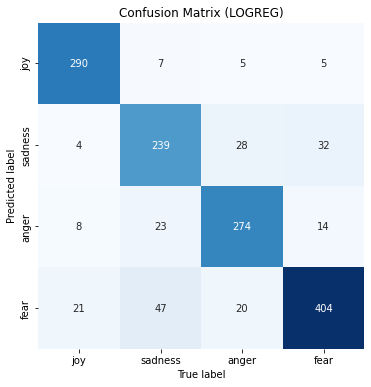

In [117]:
logModelReport= show_summary_report(y_test, logAccuracy[1], logAccuracy[2], modelTag[0], imageTag[0])

In [118]:
arrLog= []
for i in logModelReport:
    arrLog.append(i)

arrLog.append('logisticRegression tf_idfVect')
arrLog.append(runTimeLog)
arrLog.append(meanAccLog)
arrLog

[0.8494018296973962,
 0.8533691664287559,
 0.844998627117559,
 0.8485915195919422,
 0.9664365040304522,
 'logisticRegression tf_idfVect',
 1050.412654876709,
 0.8431596615754333]

#### Precision/ Recall/ Roc-Curve

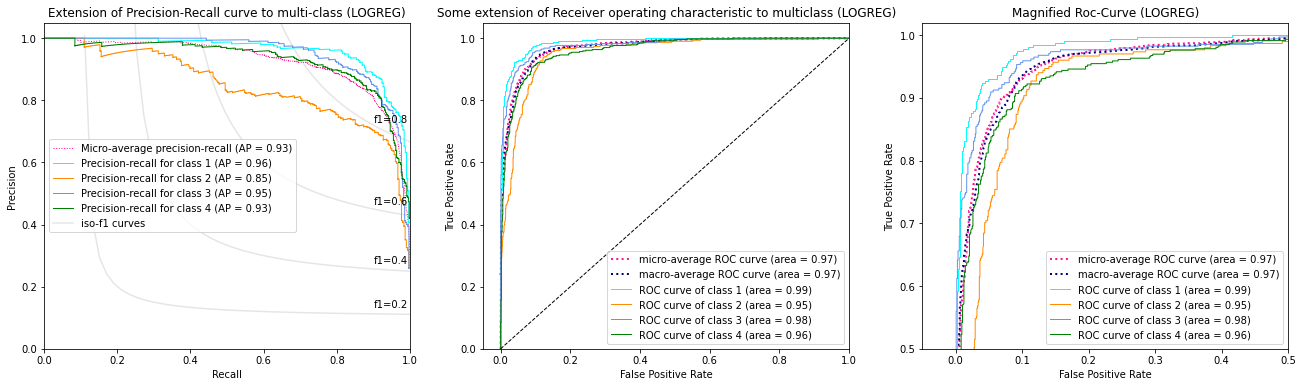

In [119]:
tfidfLogPrecisionRecallData= probaRocPrecisionRecall(X, y, log01, tfidf_vect, modelTag[0], imageTag[1])

### Support Vector Machine

#### Accuracy Score

In [120]:
%%time
tic02= time.time()
# Support Vector Machine on Word Level TF IDF Vectors
svcAccuracy= svc_train_model(svc01, X_train_tfidf, y_train, X_test_tfidf, y_test)
print('SVM, WordLevel TF-IDF : %.4f\n' % svcAccuracy[0])
toc02= time.time()
runTimeSvc= (toc02-tic02)*1000

SVM, WordLevel TF-IDF : 0.8600

CPU times: total: 250 ms
Wall time: 244 ms


#### Confusion Matrix

Accuracy  : 0.8600 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision : 0.8604 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall    : 0.8569 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
f1-score  : 0.8585 [2 * (Precision * Recall)/ (Precision + Recall)]                    Best: 1, Worst: 0
ROC AUC   : 0.9697                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


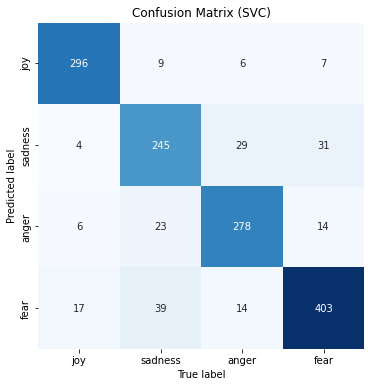

In [121]:
svcModelReport= show_summary_report(y_test, svcAccuracy[1], svcAccuracy[2], modelTag[1], imageTag[2])

#### 5-fold cross validation

In [122]:
reg= svc01
crossValScoreSvc= cross_val_score(reg, X_train_tfidf, y_train, cv=5)
meanAccSvc= np.mean(crossValScoreSvc)
print(crossValScoreSvc, meanAccSvc)

[0.86279683 0.84330986 0.85475352 0.86091549 0.85915493] 0.8561861273179977


In [123]:
arrSvc= []
for i in svcModelReport:
    arrSvc.append(i)

arrSvc.append('supportVectorMachine tf_idfVect')
arrSvc.append(runTimeSvc)
arrSvc.append(meanAccSvc)
arrSvc

[0.8599577762139339,
 0.8604374848323385,
 0.8568980788349788,
 0.8585290290985841,
 0.9696695170107956,
 'supportVectorMachine tf_idfVect',
 243.3483600616455,
 0.8561861273179977]

#### Precision/ Recall/ Roc-Curve

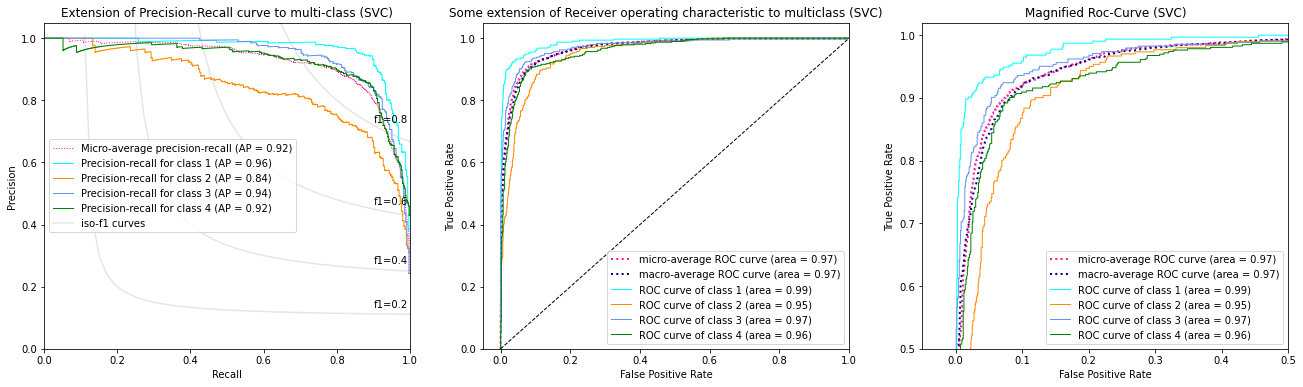

In [124]:
tfidfSvcPrecisionRecallData= svcRocPrecisionRecall(X, y, svc01, tfidf_vect, modelTag[1], imageTag[3])

### Random Forest Classifier

#### Accuracy Score

In [125]:
%%time
tic03= time.time()
# Bagging (Random Forest) on Count Vectors
rfcAccuracy= train_model(rfc02, X_train_count, y_train, X_test_count, y_test)
print('RFC, Count Vectors : %.4f\n' % rfcAccuracy[0])
toc03= time.time()
runTimeRfc= (toc03-tic03)*1000

RFC, Count Vectors : 0.8388

CPU times: total: 562 ms
Wall time: 567 ms


#### Confusion Matrix

Accuracy  : 0.8388 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision : 0.8728 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall    : 0.8260 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
f1-score  : 0.8403 [2 * (Precision * Recall)/ (Precision + Recall)]                    Best: 1, Worst: 0
ROC AUC   : 0.9706                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


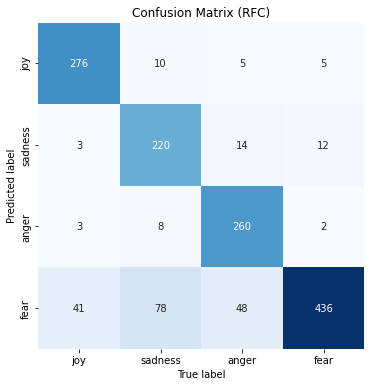

In [126]:
rfcModelReport= show_summary_report(y_test, rfcAccuracy[1], rfcAccuracy[2], modelTag[2], imageTag[4])

#### 5-fold cross validation

In [127]:
reg= rfc02
crossValScoreRfc= cross_val_score(reg, X_train_count, y_train, cv=5)
meanAccRfc= np.mean(crossValScoreRfc)
print(crossValScoreRfc, meanAccRfc)

[0.82058047 0.80457746 0.82306338 0.83274648 0.82394366] 0.8209822921699061


In [128]:
arrRfc= []
for i in rfcModelReport:
    arrRfc.append(i)

arrRfc.append('randomForestClassifier countVect')
arrRfc.append(runTimeRfc)
arrRfc.append(meanAccRfc)
arrRfc

[0.8388458831808585,
 0.8728497327445357,
 0.8260101219032898,
 0.8403463076630107,
 0.9706388310402109,
 'randomForestClassifier countVect',
 567.481279373169,
 0.8209822921699061]

#### Precision/ Recall/ Roc-Curve

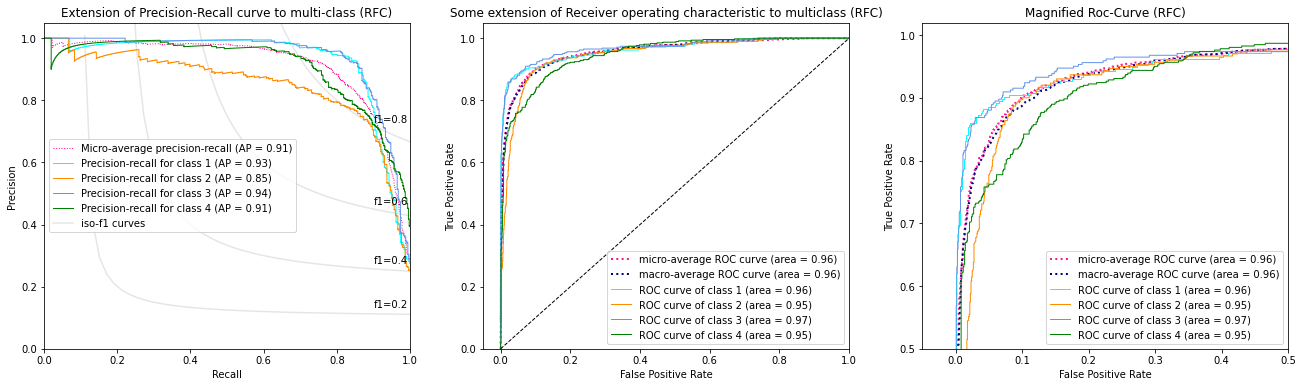

In [129]:
countRfcPrecisionRecallData= probaRocPrecisionRecall(X, y, rfc02, count_vect, modelTag[2], imageTag[5])

### Naive Bayes (Multinomial)

#### Accuracy Score

In [130]:
%%time
tic04= time.time()
# Naive Bayes on Count Vectors
gnbAccuracy = train_model(gnb01, X_train_count, y_train, X_test_count, y_test)
print('NB, Count Vectors : %.4f\n' % gnbAccuracy[0])
toc04= time.time()
runTimeGnb= (toc04-tic04)*1000

NB, Count Vectors : 0.8304

CPU times: total: 15.6 ms
Wall time: 4.03 ms


#### Confusion Matrix

Accuracy  : 0.8304 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision : 0.8331 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall    : 0.8245 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
f1-score  : 0.8272 [2 * (Precision * Recall)/ (Precision + Recall)]                    Best: 1, Worst: 0
ROC AUC   : 0.9500                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


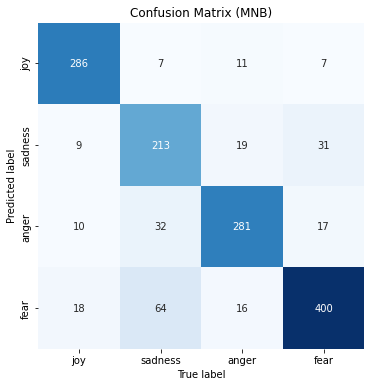

In [131]:
gnbModelReport= show_summary_report(y_test, gnbAccuracy[1], gnbAccuracy[2], modelTag[3], imageTag[6])

#### 5-fold cross validation

In [132]:
reg= gnb01
crossValScoreGnb= cross_val_score(reg, X_train_count, y_train, cv=5)
meanAccGnb= np.mean(crossValScoreGnb)
print(crossValScoreGnb, meanAccGnb)

[0.80650836 0.80897887 0.78785211 0.7931338  0.79577465] 0.7984495583881477


In [133]:
arrGnb= []
for i in gnbModelReport:
    arrGnb.append(i)

arrGnb.append('naiveBayes countVect')
arrGnb.append(runTimeGnb)
arrGnb.append(meanAccGnb)
arrGnb

[0.8304011259676284,
 0.8330964557112506,
 0.8244869113915806,
 0.8271827657813136,
 0.9500317834192038,
 'naiveBayes countVect',
 4.0283203125,
 0.7984495583881477]

#### Precision/ Recall/ Roc-Curve

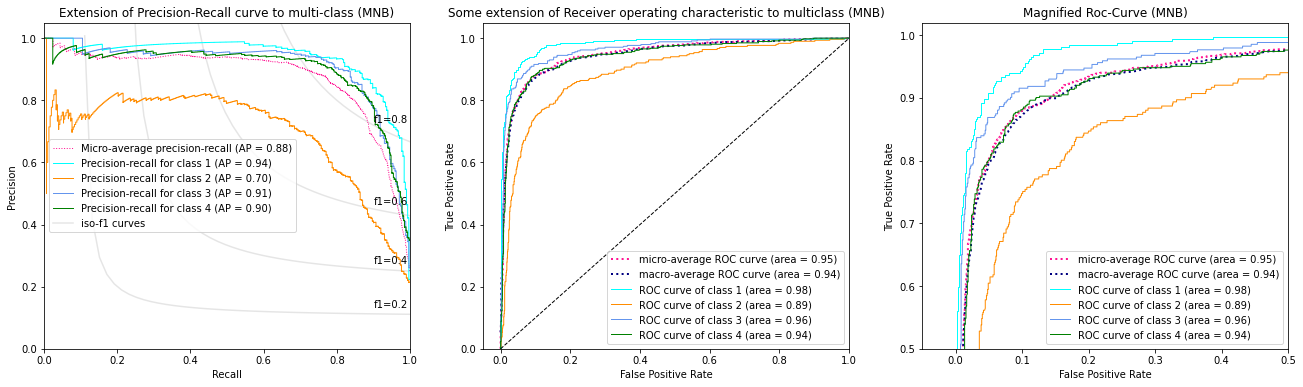

In [134]:
countGnbPrecisionRecallData= probaRocPrecisionRecall(X, y, gnb01, count_vect, modelTag[3], imageTag[7])

### Gradient Boosting

#### Accuracy Score

In [135]:
%%time
tic05= time.time()
# Gradient Boosting on Count Vectors
gradBstAccuracy = train_model(gradBst01, X_train_count, y_train, X_test_count, y_test)
print('NB, Count Vectors : %.4f\n' % gradBstAccuracy[0])
toc05= time.time()
runTimeGradBst= (toc05-tic05)*1000

NB, Count Vectors : 0.8536

CPU times: total: 4.39 s
Wall time: 4.39 s


#### Confusion Matrix

Accuracy  : 0.8536 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision : 0.8781 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall    : 0.8453 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
f1-score  : 0.8565 [2 * (Precision * Recall)/ (Precision + Recall)]                    Best: 1, Worst: 0
ROC AUC   : 0.9737                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


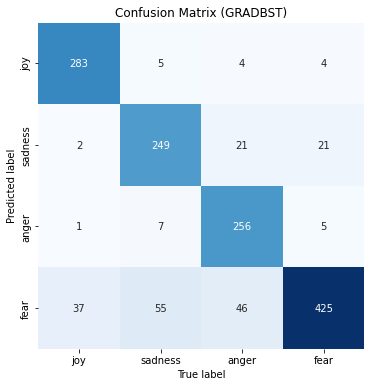

In [136]:
gradBstModelReport= show_summary_report(y_test, gradBstAccuracy[1], gradBstAccuracy[2], modelTag[4],
                                        imageTag[8])

#### 5-fold cross validation

In [137]:
reg= gradBst01
crossValScoreGradBst= cross_val_score(reg, X_train_count, y_train, cv=5)
meanAccGradBst= np.mean(crossValScoreGradBst)
print(crossValScoreGradBst, meanAccGradBst)

[0.84608619 0.83098592 0.85299296 0.8459507  0.83626761] 0.8424566749662443


In [138]:
arrGradBst= []
for i in gradBstModelReport:
    arrGradBst.append(i)

arrGradBst.append('gradientBoosting countVect')
arrGradBst.append(runTimeGradBst)
arrGradBst.append(meanAccGradBst)
arrGradBst

[0.8536242083040113,
 0.8781169605349302,
 0.8452690565148289,
 0.8565357380908434,
 0.9736924327781304,
 'gradientBoosting countVect',
 4394.27638053894,
 0.8424566749662443]

#### Precision/ Recall/ Roc-Curve

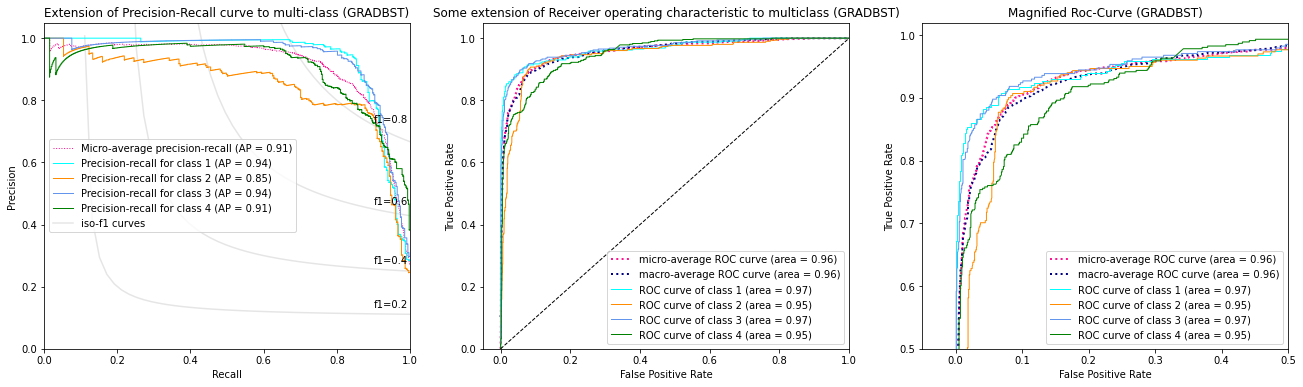

In [139]:
countGradBstPrecisionRecallData= probaRocPrecisionRecall(X, y, gradBst01, count_vect, modelTag[4],
                                                         imageTag[9])

### Stacking Count Vectors

#### Accuracy Score

In [140]:
%%time
tic06= time.time()
# Stacking on Count Vectors
sclfCountAccuracy = train_model(sclf01, X_train_count, y_train, X_test_count, y_test)
print('SCLF, Count Vectors : %.4f\n' % sclfCountAccuracy[0])
toc06= time.time()
runTimeSclfCount= (toc06-tic06)*1000

SCLF, Count Vectors : 0.8740

CPU times: total: 19.3 s
Wall time: 19.3 s


#### Confusion Matrix

Accuracy  : 0.8740 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision : 0.8780 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall    : 0.8696 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
f1-score  : 0.8731 [2 * (Precision * Recall)/ (Precision + Recall)]                    Best: 1, Worst: 0
ROC AUC   : 0.9742                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


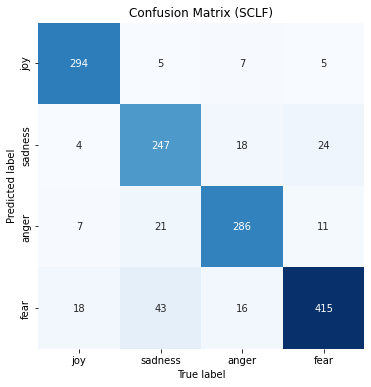

In [141]:
sclfCountModelReport= show_summary_report(y_test, sclfCountAccuracy[1], sclfCountAccuracy[2],
                                     modelTag[5], imageTag[10])

#### 5-fold cross validation

In [142]:
reg= sclf01
crossValScoreSclfCount= cross_val_score(reg, X_train_count, y_train, cv=5)
meanAccSclfCount= np.mean(crossValScoreSclfCount)
print(crossValScoreSclfCount, meanAccSclfCount)

[0.86191733 0.84859155 0.84947183 0.85387324 0.85739437] 0.8542496624425533


In [143]:
arrSclfCount= []
for i in sclfCountModelReport:
    arrSclfCount.append(i)

arrSclfCount.append('stacking countVect')
arrSclfCount.append(runTimeSclfCount)
arrSclfCount.append(meanAccSclfCount)
arrSclfCount

[0.8740323715693173,
 0.8779592421268527,
 0.8696419842443693,
 0.8730908019089261,
 0.9742475176049458,
 'stacking countVect',
 19341.211318969727,
 0.8542496624425533]

#### Precision/ Recall/ Roc-Curve

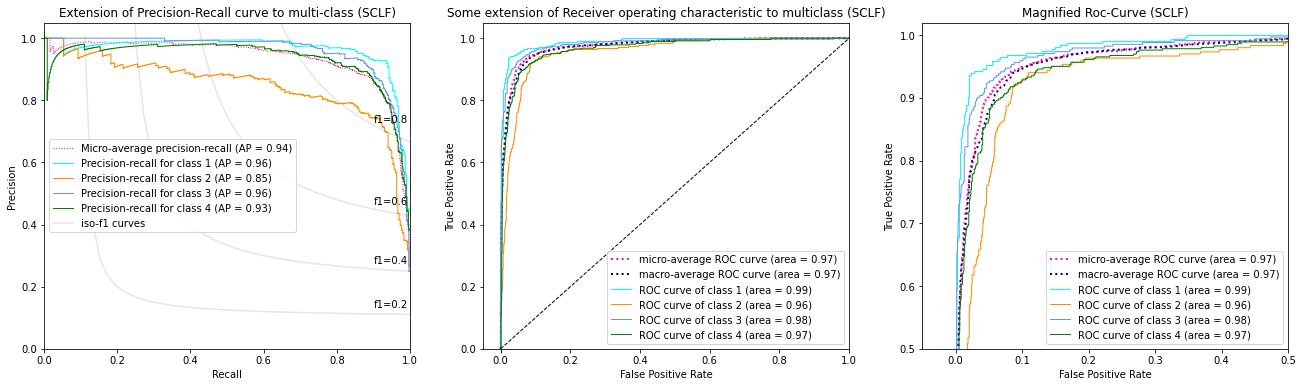

In [144]:
countSclfPrecisionRecallData= probaRocPrecisionRecall(X, y, sclf01, count_vect,
                                                     modelTag[5], imageTag[11])

### Stacking tf-idf Vectors

#### Accuracy Score

In [145]:
%%time
tic07= time.time()
# Stacking on Word Level TF IDF Vectors
sclfTfidfAccuracy = train_model(sclf01, X_train_tfidf, y_train, X_test_tfidf, y_test)
print('SCLF, WordLevel TF-IDF : %.4f\n' % sclfTfidfAccuracy[0])
toc07= time.time()
runTimeSclfTfidf= (toc07-tic07)*1000

SCLF, WordLevel TF-IDF : 0.8719

CPU times: total: 12.8 s
Wall time: 12.8 s


#### Confusion Matrix

Accuracy  : 0.8719 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision : 0.8733 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall    : 0.8693 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
f1-score  : 0.8711 [2 * (Precision * Recall)/ (Precision + Recall)]                    Best: 1, Worst: 0
ROC AUC   : 0.9735                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


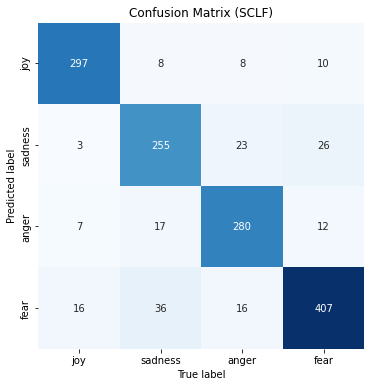

In [146]:
sclfTfidfModelReport= show_summary_report(y_test, sclfTfidfAccuracy[1], sclfTfidfAccuracy[2],
                                     modelTag[5], imageTag[12])

#### 5-fold cross validation

In [147]:
reg= sclf01
crossValScoreSclfTfidf= cross_val_score(reg, X_train_tfidf, y_train, cv=5)
meanAccSclfTfidf= np.mean(crossValScoreSclfTfidf)
print(crossValScoreSclfTfidf, meanAccSclfTfidf)

[0.87335092 0.85035211 0.86003521 0.86971831 0.86003521] 0.8626983537106545


In [148]:
arrSclfTfidf= []
for i in sclfTfidfModelReport:
    arrSclfTfidf.append(i)

arrSclfTfidf.append('stacking tfidfVect')
arrSclfTfidf.append(runTimeSclfTfidf)
arrSclfTfidf.append(meanAccSclfTfidf)
arrSclfTfidf

[0.8719211822660099,
 0.8732603977753095,
 0.8693103192336613,
 0.871077654426037,
 0.9735054227897539,
 'stacking tfidfVect',
 12786.884784698486,
 0.8626983537106545]

#### Precision/ Recall/ Roc-Curve

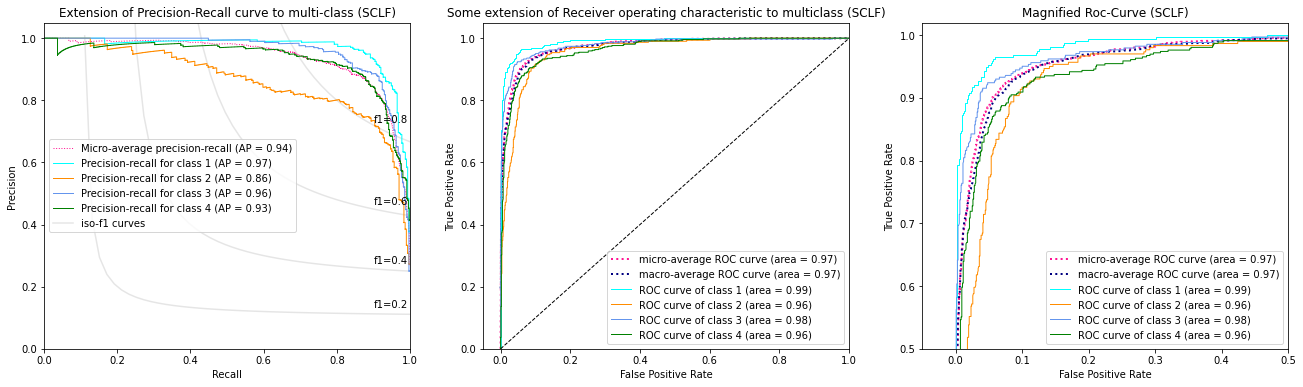

In [149]:
tfidfSclfPrecisionRecallData= probaRocPrecisionRecall(X, y, sclf01, tfidf_vect,
                                                     modelTag[5], imageTag[13])

In [150]:
imageTag[13]

'image28'

### Learning Curve

In [151]:
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

In [152]:
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

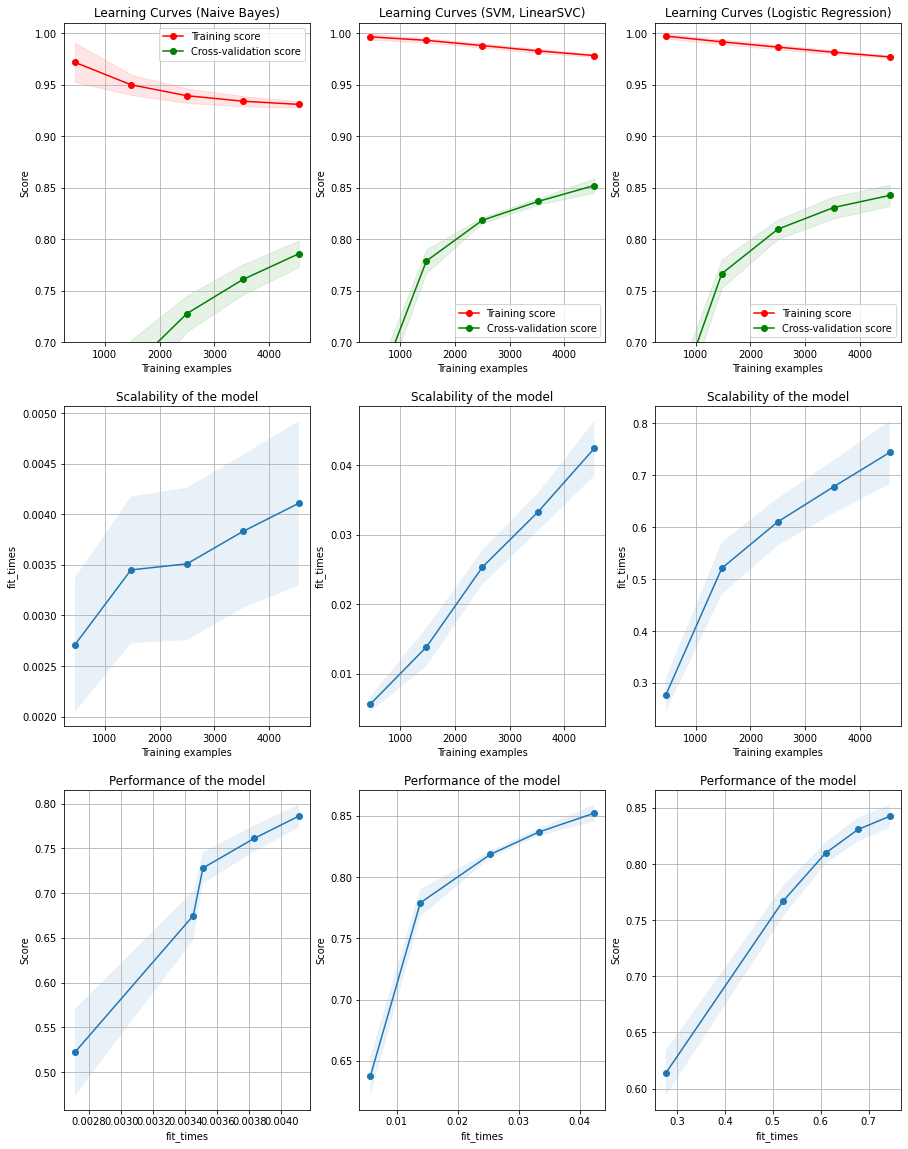

CPU times: total: 3.61 s
Wall time: 41 s


In [165]:
%%time
fig, axes = plt.subplots(3, 3, figsize=(15, 20))

# X, y = load_digits(return_X_y=True)

title = "Learning Curves (Naive Bayes)"
# Cross validation with 50 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits= 50, test_size= 0.2, random_state= 0)

estimator = gnb01
plot_learning_curve(
    estimator, title, X_train_tfidf, y_train, axes= axes[:, 0], ylim= (0.7, 1.01), cv= cv, n_jobs= 4
)

# title = r"Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
title = r"Learning Curves (SVM, LinearSVC)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits= 10, test_size= 0.2, random_state= 0)
# estimator = svm.SVC(kernel= 'rbf', gamma=0.001)
estimator = svc01
plot_learning_curve(
    estimator, title, X_train_tfidf, y_train, axes= axes[:, 1], ylim= (0.7, 1.01), cv= cv, n_jobs= 4
)

title = "Learning Curves (Logistic Regression)"
# Cross validation with 50 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits= 50, test_size= 0.2, random_state= 0)

# estimator = LogisticRegression()
estimator = log01
plot_learning_curve(
    estimator, title, X_train_tfidf, y_train, axes= axes[:, 2], ylim= (0.7, 1.01), cv= cv, n_jobs= 4
)

plt.savefig('image29.png', facecolor='w', bbox_inches="tight",
            pad_inches=0.3, transparent=True)

plt.show()

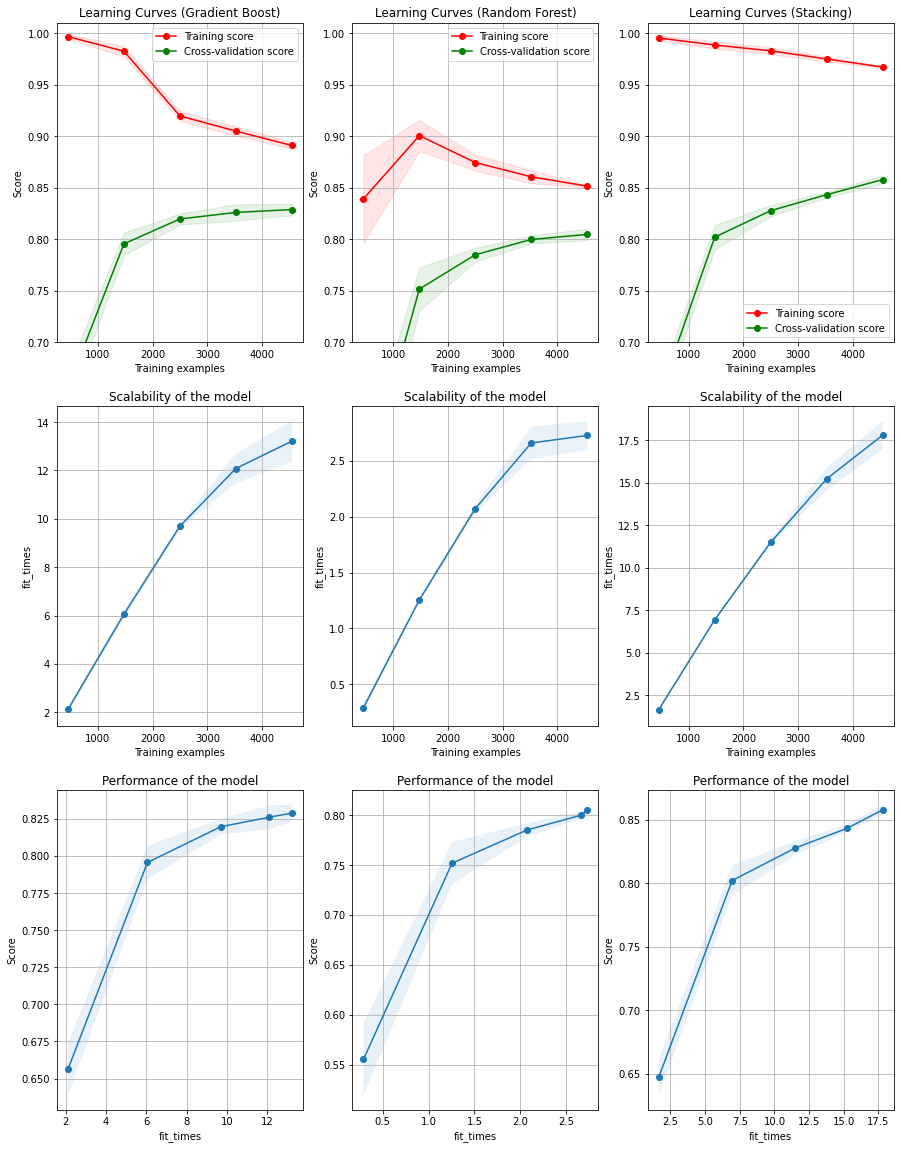

CPU times: total: 2.03 s
Wall time: 2min 30s


In [166]:
%%time
fig, axes = plt.subplots(3, 3, figsize=(15, 20))

# X, y = load_digits(return_X_y=True)

title = "Learning Curves (Gradient Boost)"
# Cross validation with 50 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits= 5, test_size= 0.2, random_state= 0)

estimator = gradBst01
plot_learning_curve(
    estimator, title, X_train_tfidf, y_train, axes= axes[:, 0], ylim= (0.7, 1.01), cv= cv, n_jobs= 4
)

# title = r"Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
title = r"Learning Curves (Random Forest)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits= 5, test_size= 0.2, random_state= 0)
# estimator = svm.SVC(kernel= 'rbf', gamma=0.001)
estimator = rfc02
plot_learning_curve(
    estimator, title, X_train_tfidf, y_train, axes= axes[:, 1], ylim= (0.7, 1.01), cv= cv, n_jobs= 4
)

title = "Learning Curves (Stacking)"
# Cross validation with 50 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits= 5, test_size= 0.2, random_state= 0)

# estimator = LogisticRegression()
estimator = sclf01
plot_learning_curve(
    estimator, title, X_train_tfidf, y_train, axes= axes[:, 2], ylim= (0.7, 1.01), cv= cv, n_jobs= 4
)

plt.savefig('image30.png', facecolor='w', bbox_inches="tight",
            pad_inches=0.3, transparent=True)

plt.show()

### Phase 02 Model Comparison

In [155]:
modelArr= []
modelArr.append(arrLog)
modelArr.append(arrSvc)
modelArr.append(arrRfc)
modelArr.append(arrGnb)
modelArr.append(arrGradBst)
modelArr.append(arrSclfCount)
modelArr.append(arrSclfTfidf)

modelArr

[[0.8494018296973962,
  0.8533691664287559,
  0.844998627117559,
  0.8485915195919422,
  0.9664365040304522,
  'logisticRegression tf_idfVect',
  1050.412654876709,
  0.8431596615754333],
 [0.8599577762139339,
  0.8604374848323385,
  0.8568980788349788,
  0.8585290290985841,
  0.9696695170107956,
  'supportVectorMachine tf_idfVect',
  243.3483600616455,
  0.8561861273179977],
 [0.8388458831808585,
  0.8728497327445357,
  0.8260101219032898,
  0.8403463076630107,
  0.9706388310402109,
  'randomForestClassifier countVect',
  567.481279373169,
  0.8209822921699061],
 [0.8304011259676284,
  0.8330964557112506,
  0.8244869113915806,
  0.8271827657813136,
  0.9500317834192038,
  'naiveBayes countVect',
  4.0283203125,
  0.7984495583881477],
 [0.8536242083040113,
  0.8781169605349302,
  0.8452690565148289,
  0.8565357380908434,
  0.9736924327781304,
  'gradientBoosting countVect',
  4394.27638053894,
  0.8424566749662443],
 [0.8740323715693173,
  0.8779592421268527,
  0.8696419842443693,
  0.

In [156]:
comparisonCols= ['accuracy', 'precision', 'recall', 'f1-score', 'roc_auc', 'model', 'runtime (ms)',
                 'meanAcc']

In [157]:
dfModCompare= pd.DataFrame(modelArr, columns= comparisonCols)
dfModCompare

,accuracy,precision,recall,f1-score,roc_auc,model,runtime (ms),meanAcc
0,0.849402,0.853369,0.844999,0.848592,0.966437,logisticRegression tf_idfVect,1050.412655,0.843160
1,0.859958,0.860437,0.856898,0.858529,0.969670,supportVectorMachine tf_idfVect,243.348360,0.856186
2,0.838846,0.872850,0.826010,0.840346,0.970639,randomForestClassifier countVect,567.481279,0.820982
3,0.830401,0.833096,0.824487,0.827183,0.950032,naiveBayes countVect,4.028320,0.798450
4,0.853624,0.878117,0.845269,0.856536,0.973692,gradientBoosting countVect,4394.276381,0.842457
5,0.874032,0.877959,0.869642,0.873091,0.974248,stacking countVect,19341.211319,0.854250
6,0.871921,0.873260,0.869310,0.871078,0.973505,stacking tfidfVect,12786.884785,0.862698


In [158]:
modelIndex= dfModCompare.copy(deep=True)
modelIndex.set_index('model', inplace=True)
modelIndex

,accuracy,precision,recall,f1-score,roc_auc,runtime (ms),meanAcc
model,,,,,,,
logisticRegression tf_idfVect,0.849402,0.853369,0.844999,0.848592,0.966437,1050.412655,0.843160
supportVectorMachine tf_idfVect,0.859958,0.860437,0.856898,0.858529,0.969670,243.348360,0.856186
randomForestClassifier countVect,0.838846,0.872850,0.826010,0.840346,0.970639,567.481279,0.820982
naiveBayes countVect,0.830401,0.833096,0.824487,0.827183,0.950032,4.028320,0.798450
gradientBoosting countVect,0.853624,0.878117,0.845269,0.856536,0.973692,4394.276381,0.842457
stacking countVect,0.874032,0.877959,0.869642,0.873091,0.974248,19341.211319,0.854250
stacking tfidfVect,0.871921,0.873260,0.869310,0.871078,0.973505,12786.884785,0.862698


In [159]:
filepath = Path('modelComparison.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
modelIndex.to_csv(filepath)

### Comparison Precision/ Recall/ Roc-Curve

In [160]:
from itertools import cycle

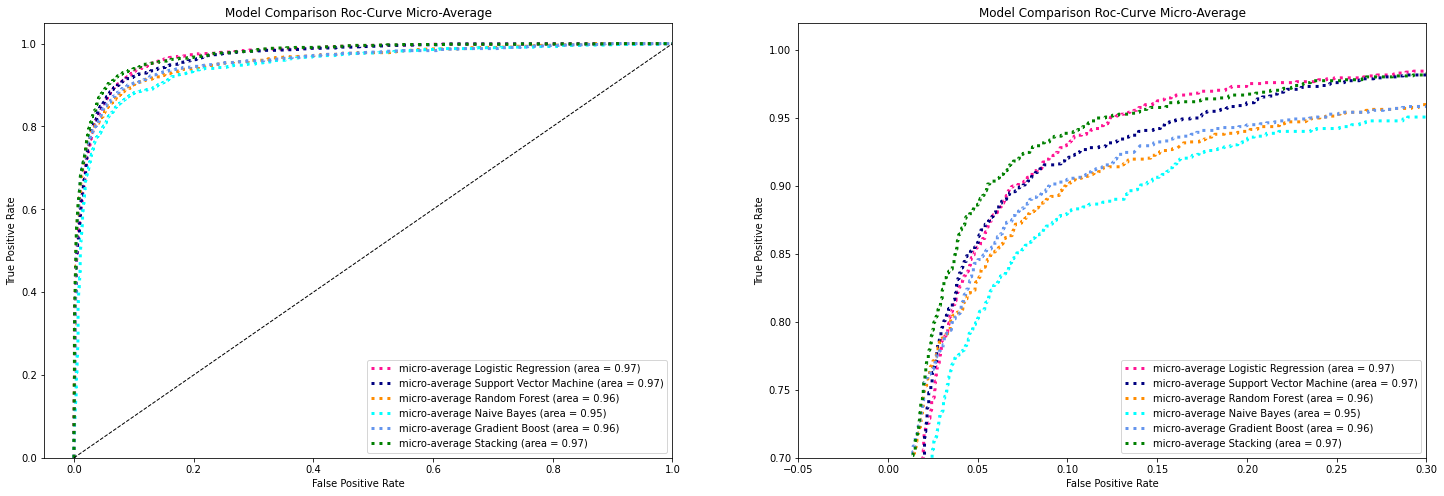

In [163]:
# Plot all ROC curves
fig, ax= plt.subplots(1, 2, figsize= (20, 8))
fig.subplots_adjust(left= 0.02, right= 0.98, wspace= 0.2)
#     plt.figure(figsize=(10, 7))
colors = cycle(['deeppink', 'navy', 'darkorange', 'aqua', 'cornflowerblue', 'green', 'red'])
lw= 1
for i in range(0, 2):
    ax[i].plot(
        tfidfLogPrecisionRecallData[4],
        tfidfLogPrecisionRecallData[5],
        label="micro-average Logistic Regression (area = {0:0.2f})".format(tfidfLogPrecisionRecallData[6]),
        color="deeppink",
        linestyle=":",
        linewidth=3,
    )
    ax[i].plot(
        tfidfSvcPrecisionRecallData[4],
        tfidfSvcPrecisionRecallData[5],
        label="micro-average Support Vector Machine (area = {0:0.2f})".format(tfidfSvcPrecisionRecallData[6]),
        color="navy",
        linestyle=":",
        linewidth=3,
    )  
    ax[i].plot(
        countRfcPrecisionRecallData[4],
        countRfcPrecisionRecallData[5],
        label="micro-average Random Forest (area = {0:0.2f})".format(countRfcPrecisionRecallData[6]),
        color="darkorange",
        linestyle=":",
        linewidth=3,
    )
    ax[i].plot(
        countGnbPrecisionRecallData[4],
        countGnbPrecisionRecallData[5],
        label="micro-average Naive Bayes (area = {0:0.2f})".format(countGnbPrecisionRecallData[6]),
        color="aqua",
        linestyle=":",
        linewidth=3,
    )
    ax[i].plot(
        countGradBstPrecisionRecallData[4],
        countGradBstPrecisionRecallData[5],
        label="micro-average Gradient Boost (area = {0:0.2f})".format(countGradBstPrecisionRecallData[6]),
        color="cornflowerblue",
        linestyle=":",
        linewidth=3,
    )
    ax[i].plot(
        tfidfSclfPrecisionRecallData[4],
        tfidfSclfPrecisionRecallData[5],
        label="micro-average Stacking (area = {0:0.2f})".format(tfidfSclfPrecisionRecallData[6]),
        color="green",
        linestyle=":",
        linewidth=3,
    )
ax[0].plot([0, 1], [0, 1], "k--", lw= lw)
ax[0].set_xlim([-0.05, 1.0])
ax[0].set_ylim([0.0, 1.05])
ax[0].set_xlabel("False Positive Rate")
ax[0].set_ylabel("True Positive Rate")
ax[0].set_title("Model Comparison Roc-Curve Micro-Average")
ax[0].legend(loc="lower right")

ax[1].plot([0, 1], [0, 1], "k--", lw= lw)
ax[1].set_xlim([-0.05, 0.3])
ax[1].set_ylim([0.7, 1.02])
ax[1].set_xlabel("False Positive Rate")
ax[1].set_ylabel("True Positive Rate")
ax[1].set_title("Model Comparison Roc-Curve Micro-Average")
ax[1].legend(loc="lower right")

plt.savefig('image31.png', facecolor='w', bbox_inches="tight",
            pad_inches=0.3, transparent=True)
plt.show()

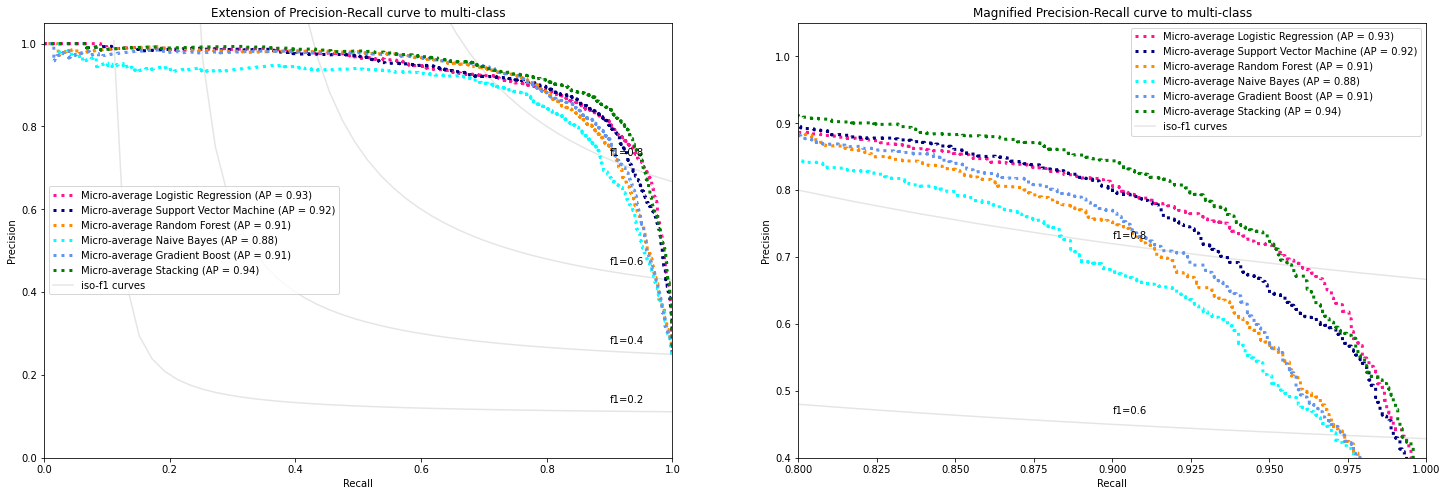

In [164]:
# plot
fig, ax= plt.subplots(1, 2, figsize= (20, 8))
fig.subplots_adjust(left= 0.02, right= 0.98, wspace= 0.2)
colors = cycle(['deeppink', 'navy', 'darkorange', 'aqua', 'cornflowerblue', 'green', 'red'])
# Precision/Recall
f_scores = np.linspace(0.2, 0.8, num=4)
lines, labels = [], []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    (l,) = ax[0].plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
    ax[0].annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))
    (l,) = ax[1].plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
    ax[1].annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

for i in range(0, 2):
#     print(i)
    display= PrecisionRecallDisplay(
        recall= tfidfLogPrecisionRecallData[11],
        precision= tfidfLogPrecisionRecallData[10],
        average_precision= tfidfLogPrecisionRecallData[12],
    )
    display.plot(ax= ax[i], name="Micro-average Logistic Regression", color="deeppink", linewidth= 3,
                 linestyle=':')
    display= PrecisionRecallDisplay(
        recall= tfidfSvcPrecisionRecallData[11],
        precision= tfidfSvcPrecisionRecallData[10],
        average_precision= tfidfSvcPrecisionRecallData[12],
    )
    display.plot(ax= ax[i], name="Micro-average Support Vector Machine", color="navy", linewidth= 3,
                 linestyle=':')
    display= PrecisionRecallDisplay(
        recall= countRfcPrecisionRecallData[11],
        precision= countRfcPrecisionRecallData[10],
        average_precision= countRfcPrecisionRecallData[12],
    )
    display.plot(ax= ax[i], name="Micro-average Random Forest", color="darkorange", linewidth= 3,
                 linestyle=':')
    display= PrecisionRecallDisplay(
        recall= countGnbPrecisionRecallData[11],
        precision= countGnbPrecisionRecallData[10],
        average_precision= countGnbPrecisionRecallData[12],
    )
    display.plot(ax= ax[i], name="Micro-average Naive Bayes", color="aqua", linewidth= 3,
                 linestyle=':')
    display= PrecisionRecallDisplay(
        recall= countGradBstPrecisionRecallData[11],
        precision= countGradBstPrecisionRecallData[10],
        average_precision= countGradBstPrecisionRecallData[12],
    )
    display.plot(ax= ax[i], name="Micro-average Gradient Boost", color="cornflowerblue", linewidth= 3,
                 linestyle=':')
    display= PrecisionRecallDisplay(
        recall= tfidfSclfPrecisionRecallData[11],
        precision= tfidfSclfPrecisionRecallData[10],
        average_precision= tfidfSclfPrecisionRecallData[12],
    )
    display.plot(ax= ax[i], name="Micro-average Stacking", color="green", linewidth= 3,
                 linestyle=':')

# add the legend for the iso-f1 curves
handles, labels = display.ax_.get_legend_handles_labels()
handles.extend([l])
labels.extend(["iso-f1 curves"])
# set the legend and the axes
ax[0].set_xlim([0.0, 1.0])
ax[0].set_ylim([0.0, 1.05])
ax[0].legend(handles=handles, labels=labels, loc="best")
ax[0].set_title(f'Extension of Precision-Recall curve to multi-class')

handles, labels = display.ax_.get_legend_handles_labels()
handles.extend([l])
labels.extend(["iso-f1 curves"])
ax[1].set_xlim([0.8, 1.0])
ax[1].set_ylim([0.4, 1.05])
ax[1].legend(handles=handles, labels=labels, loc="best")
ax[1].set_title(f'Magnified Precision-Recall curve to multi-class')

plt.savefig('image32.png', facecolor='w', bbox_inches="tight",
            pad_inches=0.3, transparent=True)
plt.show()

### Chosen Model

Support Vecter Machine (tf-idf Vector) LinearSVC Model

Implementing the chosen legitimate model, it is able to predict with 86% confidence matching emotion to the related text as either:
- joy
- sadness
- anger
- fear